__Author(s): Chaojie Feng__<br/>
__Github: https://github.com/fcjscott__<br/>
__Collaborator(s): Individual__<br/>
__External Resources: Resourced from Jingwen Zhang's repository for smooth trajectory generation__<br/>
__Specific Contributions: ALL__<br/>
__Aggregate Contributions: 100%__<br/>

In [305]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

# fixed parameters
l = 80
w = 85
c = 10
r = 20
R = 115

# 1 Robot Model

You will again consider the 2 wheeled robot from lab 3, this time ignoring sensors and noise terms. For simplicity, you can consider the robot to be a circle of diameter 115mm. For realism, you can optionally consider the true shape of the robot to be a rectangle of length $l = 80mm$ and width $w = 85mm$; the center of the axle is $c = 10mm$ from the front of the robot. In addition, the wheel radius is $r_w = 20 mm$

The dynamics of robot can be representad as following:

$$\begin{bmatrix}\dot{x}\\ \dot{y}\\\dot{\theta} \end{bmatrix} =  \left[\begin{array}{cc} cos\theta & 0 \\
sin\theta & 0 \\ 0 & 1\end{array}\right] \begin{bmatrix} \frac{\omega_L + \omega_R}{2}r \\ \frac{-\omega_L + \omega_R}{w}r \end{bmatrix}$$

Where $\omega_L$ and $\omega_R$ represent the left and right wheel speed respectively

# 2 Trajectory Planning

The robot must move through a cluttered 2D rectangular environment representing a parking lot. You will want to
consider geometric obstacles defined by rectangles specified within the space. For additional complexity, you may
want to include ”one-way” regions in the space that only permit motion in one direction (with motion in the other
directions represented by obstacles in C-space).
The robot must achieve a prescribed goal, i.e. a desired $x, y, θ$ for the robot state. Note that this robot is
non-holonomic: you only have two input controls for the 3-DOF state.
Compute a plan to take the robot from a given initial state to the desired goal state while avoiding obstacles,
and use that to implement a planner / controller specifying the inputs to the actuators as a function of time.

## 2.1 Find the nearest node

In [260]:
class node:
    """
    Build a class of node
    """
    def __init__(self,state):
        self.state = state
        self.parent = None

def NearestNode(V, target):
    """
    Based on a set of nodes in node list {V} and a target state, find the nearest
    node in V to the target state, and return the index of that node
    
    Input: 
    V = list(class(node1), class(node2), ...)
    target = np.array([x, y, theta])
    
    Output:
    nearest_node = np.array([x, y, theta])
    min_id = index
    """
    nearest_node = np.zeros(3)
    dmin = 10**10
    min_id = None
    for i,node in enumerate(V):
        d = np.linalg.norm(target - node.state)
        if d < dmin:
            dmin = d
            nearest_node = node
            min_id = i
    
    return nearest_node, min_id 
        


Given a set of points V in C-space and a single other target point, the nearest point to the target point can be found by `NearestNode()`. It iterates through all posible nodes in V and return the closest node in the data type of numpy array. The simulation is in the following section. Red dot represents target point and yellow dot represents nearest point

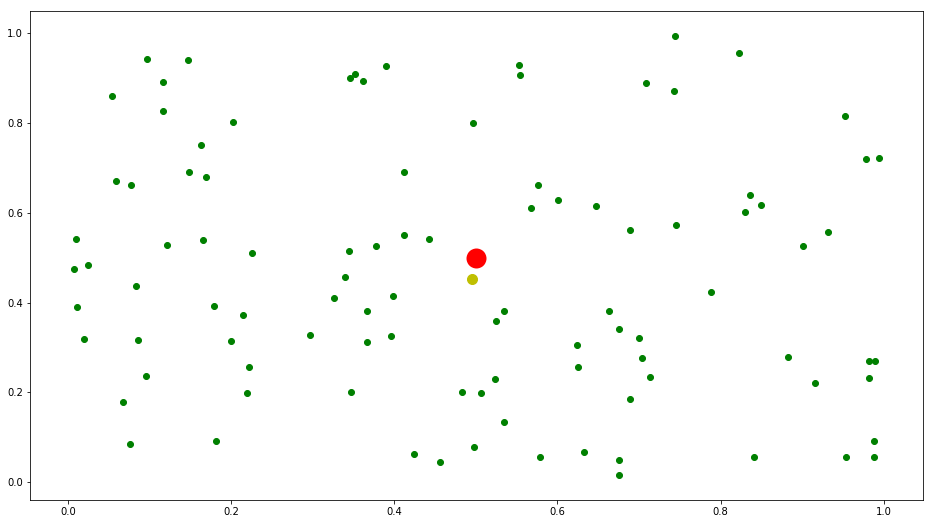

In [355]:
# Visualization of Nearest Node in 2D situation
V = []
plt.figure(figsize=(16,9))
for i in range(100):
    n = node(np.array([np.random.uniform(), np.random.uniform(), 0.5]))
    V.append(n)
    plt.scatter(V[i].state[0], V[i].state[1], c='g')

target = np.array([0.5,0.5,0.5])
plt.scatter(target[0],target[1], c='r',s = 100, linewidth = 10)
nearest_node, min_id = NearestNode(V, target)
plt.scatter(nearest_node.state[0],nearest_node.state[1], c='y', s = 100)
    

## 2.2 Generate smooth trajectories

In [356]:
def traj_generate(current_state, target_state, kr=0.3, ka=1.5, kb=-0.6, dt = 0.10, mode = 0):
    """
    Generate smooth trajectories given input state and goal state
    
    Input: 
    current_state = current position and orientation formed in numpy array [x,y,theta]
    target_state = target position and orientation formed in numpy array [x,y,theta]
    
    Output:
    trajectory = list of states along trajectory, with dt time interval
    u = list of control input
    """
    
    # extract states
    xi,yi,ti = current_state[0],current_state[1],current_state[2]
    xg,yg,tg = target_state[0],target_state[1],target_state[2]
    
    
    dx = xg - xi
    dy = yg -yi
    rho = np.sqrt(dx**2 + dy**2)
    
    #initialize trajectories
    trajectory = []
    u = []
    x,y,theta = xi,yi,ti
    
    t = 0.0
    
    while t <= 1.0 and rho >= 0.001:
        trajectory.append(np.array([x,y,theta]))
        dx = xg - x
        dy = yg -y
        
        rho = np.sqrt(dx**2 + dy**2)
        alpha = (np.arctan2(dy,dx) - theta + np.pi) %(2*np.pi) - np.pi
        beta = (tg - theta - alpha + np.pi) % (2*np.pi) - np.pi
        
        v = kr*rho
        omega = ka*alpha + kb*beta
        
        # investigate backward to control input
        omega_left = (2*v - omega*w)/(2*r)
        omega_right = (2*v + omega*w)/(2*r)
        u.append(np.array([omega_left,omega_right]))
        
        if alpha > np.pi/2 or alpha < -np.pi/2:
            v = -v
            
        theta = theta + omega*dt
        x = x + v*np.cos(theta)*dt
        y = y + v*np.sin(theta)*dt
        
        t += mode*dt
        #print(t)
        

        
    return trajectory, u
        
    
    

The trajectories of robot is defined by parametric equations. The control input of this trajectory will be $\omega_L$ and $\omega_R$ from wheels. Note that the trajectory might look not continuous in C-space, it is actually continuous if $\theta$ is taken into consideration.

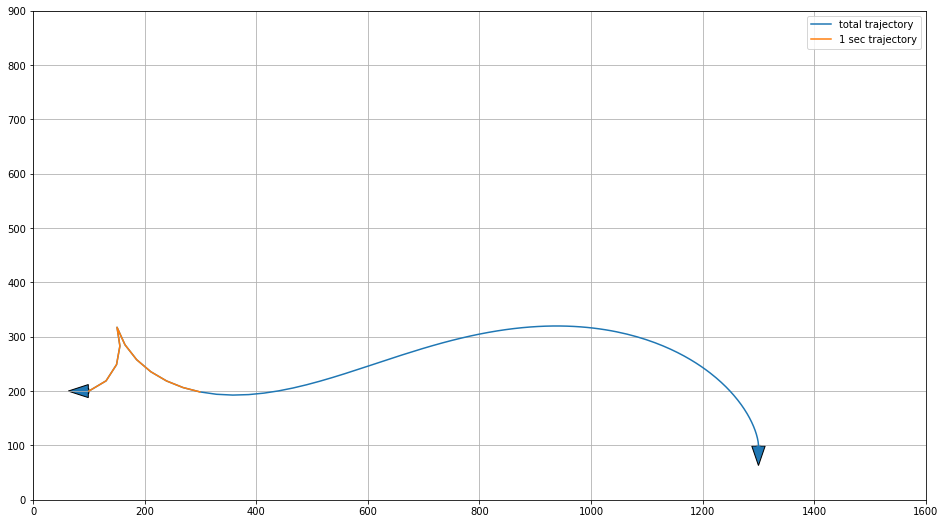

In [381]:
# simulated trajectoriies
xi = np.array([100,200,np.pi])
xf = np.array([1300,100,-np.pi/2])

traj_1s,_ = traj_generate(xi,xf,mode=0)
traj_total,_ = traj_generate(xi,xf,mode=1)
traj_1s = np.reshape(traj_1s, [len(traj_1s), 3])
traj_total = np.reshape(traj_total, [len(traj_total), 3])
plt.figure(figsize = (16,9))
plt.xlim((0,1600))
plt.ylim((0,900))
plt.plot(traj_1s[:,0],traj_1s[:,1])
plt.plot(traj_total[:,0],traj_total[:,1])
plt.arrow(xi[0],xi[1],np.cos(xi[2]),np.sin(xi[2]),width = 8)
plt.arrow(xf[0],xf[1],np.cos(xf[2]),np.sin(xf[2]),width = 8)
plt.legend(['total trajectory','1 sec trajectory'])
plt.grid(True)



## 2.3 Map Visualization in operation space and configuration space

In [532]:
def OperationSpace(current_state, target_state, obList, config = False):
    fig = plt.figure(figsize = (16,9))
    ax = fig.add_subplot(1, 1, 1)
    plt.xlim((0,1600))
    plt.ylim((0,900))
    plt.grid(True)
    plt.arrow(current_state[0], current_state[1], 
              np.cos(current_state[2]), np.sin(current_state[2]), width = 10, color = 'r')
    plt.arrow(target_state[0], target_state[1], 
              np.cos(target_state[2]), np.sin(target_state[2]), width = 10, color = 'g')
    
    if not config:
        current_circle = plt.Circle((current_state[0], current_state[1]),R/2,color = 'r',fill = 0)
        target_circle = plt.Circle((target_state[0], target_state[1]),R/2, color = 'g', fill = 0)
        ax.add_patch(current_circle)
        ax.add_patch(target_circle)
    for x in obList:
        ob = plt.Rectangle(x[0:2], x[2], x[3])
        ax.add_patch(ob)
            
        
    return ax
        
    

In order to simplify for the analysis of configuration space, the robot is modeled as a circular robot with diameter of 115 mm. The following figure shows the a virtual parking test environment. A test vehicle will need to perform head-in parking, rear-in parking as well as parallel parking in this environment

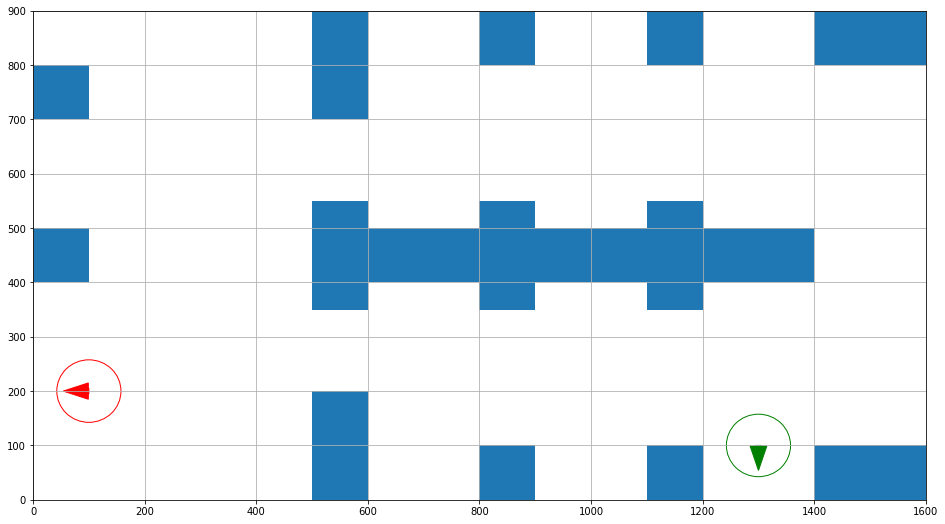

In [533]:
parkingLot = [(500, 350, 100, 200),
         (500, 0, 100, 200),
         (500,700,100,200),
         (600,400,800,100),
         (800,0,100,100),
         (1100,0,100,100),
         (1400,0,200,100),
         (800,800,100,100),
         (1100,800,100,100),
         (1400,800,200,100),
         (800,350,100,200),
         (1100,350,100,200),
         (0,700,100,100),
         (0,400,100,100)]



ax = OperationSpace(xi, xf, parkingLot)

In [534]:
def ConfigSpace(current_state,target_state,obList):
    configList = []
    ax = OperationSpace(current_state,target_state,obList,config = True)
    for x in obList:
        r1 = plt.Rectangle((x[0]-R/2,x[1]),R/2,x[3])
        r2 = plt.Rectangle((x[0]+x[2],x[1]),R/2,x[3])
        r3 = plt.Rectangle((x[0],x[1]+x[3]),x[2],R/2)
        r4 = plt.Rectangle((x[0],x[1]-R/2),x[2],R/2)
        c1 = plt.Circle((x[0],x[1]),R/2)
        c2 = plt.Circle((x[0]+x[2],x[1]),R/2)
        c3 = plt.Circle((x[0]+x[2],x[1]+x[3]),R/2)
        c4 = plt.Circle((x[0],x[1]+x[3]),R/2)
        ax.add_patch(r1)
        ax.add_patch(r2)
        ax.add_patch(r3)
        ax.add_patch(r4)
        ax.add_patch(c1)
        ax.add_patch(c2)
        ax.add_patch(c3)
        ax.add_patch(c4)
        
        
    
    return ax

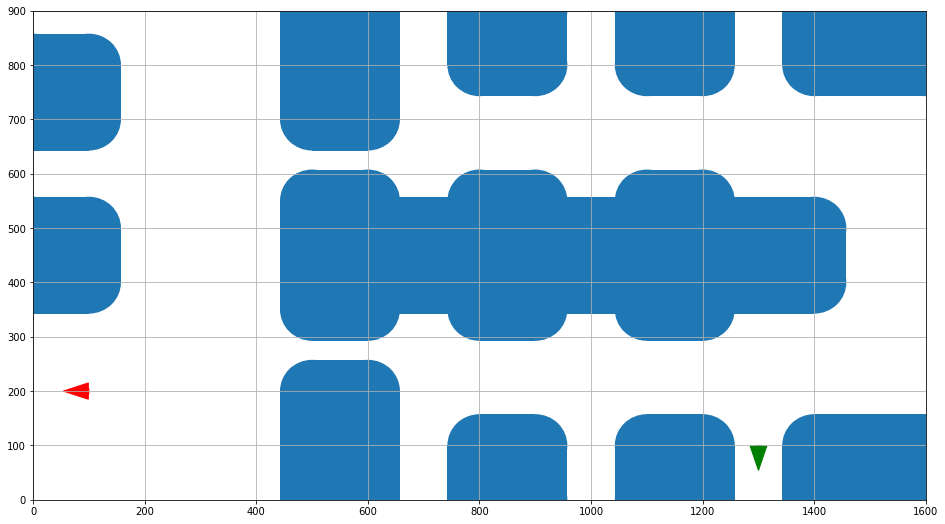

In [535]:
ax = ConfigSpace(xi,xf,parkingLot)